In [2]:
import numpy as np
import pynbody
import pynbody.units as units
import matplotlib
import matplotlib.pyplot as plt
import sys, os, glob, pickle, pylab as plt, struct

In [3]:
print(pynbody.config)

{'disk-fit-function': 'expsech', 'default-cosmology': {'omegaL0': 0.691, 'running': 0.0, 'sigma8': 0.8288, 'ns': 0.96, 'omegaB0': 0.0482, 'omegaM0': 0.309, 'h': 0.6777, 'a': 1.0}, 'threading': 'True', 'centering-scheme': 'ssc', 'gravity_calculation_mode': 'direct_omp', 'sph': {'tree-leafsize': 16, 'smooth-particles': 32}, 'number_of_threads': 128, 'snap-class-priority': [<class 'pynbody.snapshot.ramses.RamsesSnap'>, <class 'pynbody.snapshot.grafic.GrafICSnap'>, <class 'pynbody.snapshot.nchilada.NchiladaSnap'>, <class 'pynbody.snapshot.gadget.GadgetSnap'>, <class 'pynbody.snapshot.gadgethdf.EagleLikeHDFSnap'>, <class 'pynbody.snapshot.gadgethdf.GadgetHDFSnap'>, <class 'pynbody.snapshot.gadgethdf.SubFindHDFSnap'>, <class 'pynbody.snapshot.tipsy.TipsySnap'>, <class 'pynbody.snapshot.ascii.AsciiSnap'>], 'halo-class-priority': [<class 'pynbody.halo.GrpCatalogue'>, <class 'pynbody.halo.AmigaGrpCatalogue'>, <class 'pynbody.halo.legacy.RockstarIntermediateCatalogue'>, <class 'pynbody.halo.rock

In [4]:
def load_halos_pickle(pickle_path):
    
    '''
    Returns pickle as dictionary
    '''
        
    data = pickle.load( open( pickle_path , "rb" ))
    
    
    output = dict([(str(k),np.zeros(len(data))) for k in data[1]])
    
    for i in range(len(data)):
        gal_dict = data[i]
        
        if gal_dict is not None:
            for key, value in output.items():
                try:
                    value[i] = gal_dict[str(key)] + 1e-12
                except:
                    pass
    return output

In [5]:
def nihao(quantity, z):
    # Load NIHAO pickles

    NIHAO_PATH = "/scratch/kld8/pickle_NIHAO.p"

    nihao = pickle.load(open(NIHAO_PATH, 'rb'))
    
    retval = []
    
    for (k,v) in nihao.items():
        if z == 0:
            if 1.5765166949677223e-14 in v:
                halo_dict = v[1.5765166949677223e-14]
        if z == 4:
            if 4.0219197196751315 in v:
                halo_dict = v[4.0219197196751315]
        retval.append(halo_dict[quantity])
    
    return np.array(retval)

In [6]:
def density_estimate(x, y):
    
    '''
    Calculates the plot density given function m2(m1).
    Returns X, Y, Z
    '''

    from scipy import stats
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(),Y.ravel()])
    values = np.vstack([x, y])

    kernel = stats.gaussian_kde(values)

    Z = np.reshape(kernel(positions).T, X.shape)
    
    return X, Y, Z

In [8]:
#path = 'data/60/vol_halo_center_z0.205.p'
path = '/scratch/hc2347/pickles/60/CENTER60v1_0.205.p'

#path = 'data/60/1e5_vol_halo_metals_z0.205.p'
data = load_halos_pickle(path)
print(data.keys())

dict_keys(['sfr_100', 'mgas', 'ndm', 'mstar', 'mgascool', 'mvir', 'oxh', 'mdm', 'ID', 'npart', 'sfr_10', 'z_star', 'nstar', 'ngas'])


In [21]:
massf = np.where(data['mvir'] > 10**8)

In [22]:
def do_filter(a, b):
    
    def is_valid(elm):
        return elm > 1 and np.isfinite(elm)

    #print(len(b))
    for idx in range(len(b) - 1, -1, -1):
        #print(idx)
        if not is_valid(b[idx]):
            a = np.delete(a,idx)
            b = np.delete(b,idx)
    return a,b

In [10]:
matplotlib.rcParams['font.family'] = 'serif'

16268 number of points.


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


[1.73998967e+06 9.49787888e+08 1.21675802e+06 9.54153250e+07
 5.82806975e+09 6.70345494e+06 1.36801733e+07 2.00599193e+11
 7.50075668e+09 3.64883503e+08 9.35796079e+08 0.00000000e+00
 9.27708243e+07 1.59028283e+11 1.60296424e+06]
[6.10275106e+00 7.45898496e+00 6.37624966e+00 1.26634676e+00
 6.32640077e-01 8.23904968e+01 2.94897372e-01 1.97075293e-01
 6.87301556e-01 7.27363785e+00 2.34377775e+00            nan
 4.56021302e+00 4.16560435e-02 3.65420542e-01]


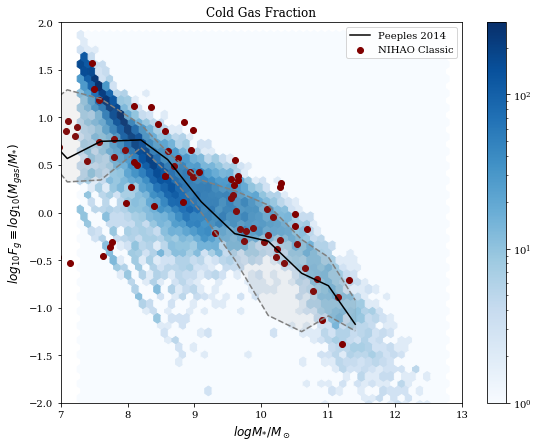

In [11]:
def plot_coldgas(mgas,mstar):
    
    mstar, mgas = do_filter(mstar, mgas)
    
    fg = mgas/mstar
    
    x = np.log10(mstar)
    y = np.log10(fg)

    
    fig, ax = plt.subplots(figsize = (9,7))
    
    print(str(len(mstar)) + ' number of points.')
    
    hb = ax.hexbin(x,y,gridsize= 50, bins='log',cmap='Blues')
    cb = fig.colorbar(hb, ax=ax)
    
    peebles = np.genfromtxt('/scratch/hc2347/references/obs/Peebles_2014_coldgas.csv',unpack=True,skip_header=2,delimiter=',')
    logmstar_pb = peebles[0]
    median_pb = peebles[1]
    sixteen_pb = peebles[2]
    eightyfour_pb = peebles[3]
    
    nihao_x = nihao('Mstar',0)
    nihao_y = nihao('Mcool',0)/nihao('Mstar',0)
    print(nihao_x[:15])
    print(nihao_y[:15])
        
    ax.scatter(np.log10(nihao_x), np.log10(nihao_y), color='maroon', label = "NIHAO Classic")
    
    ax.plot(logmstar_pb, np.log10(median_pb), c='black', label = "Peeples 2014")
    ax.plot(logmstar_pb, np.log10(sixteen_pb), linestyle='dashed',color='grey')
    ax.plot(logmstar_pb, np.log10(eightyfour_pb), linestyle='dashed',color='grey')
    ax.fill_between(logmstar_pb, np.log10(sixteen_pb), y2 = np.log10(eightyfour_pb), alpha = 0.1, color='grey')
    ax.set_ylabel('$log_{10}F_g \equiv log_{10}(M_{gas}/M_{*})$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    
    ax.set_xlim(7,13)
    ax.set_ylim(-2,2)
    #ax.set_yscale('log')
    ax.legend()

    
    plt.title("Cold Gas Fraction")
    plt.savefig("/scratch/hc2347/reports/cold_gas.png")

starfilt = np.where((data['nstar'] > 5) & (data['ngas']>10))

    
plot_coldgas(data['mgascool'][starfilt],data['mstar'][starfilt])

[9.12367208 9.16368956 9.09482136 9.15394892        nan 8.91731962
 9.13811119 9.15889307 9.00768711 9.1165467  9.14937818 9.17023442
 9.06786886 9.01647752 8.93574358 9.07341062 9.20005495 9.17282386
 9.32710449 8.86617565 9.12316079 9.00114612 8.95625972 9.00187654
 8.84512537 9.07362523 9.15577325 9.13067466 9.17926966 9.06723187
 8.98008503 9.14150123        nan 8.96499681 9.01662131 9.09081788
 9.07856378 9.02091609 9.17991972 9.03193173]
63735
[9.12367208 9.16368956 9.09482136 9.15394892        nan 8.91731962
 9.13811119 9.15889307 9.00768711 9.1165467  9.14937818 9.17023442
 9.06786886 9.01647752 8.93574358 9.07341062 9.20005495 9.17282386
 9.32710449 8.86617565 9.12316079 9.00114612 8.95625972 9.00187654
 8.84512537 9.07362523 9.15577325 9.13067466 9.17926966 9.06723187
 8.98008503 9.14150123        nan 8.96499681 9.01662131 9.09081788
 9.07856378 9.02091609 9.17991972 9.03193173]
40567
40567


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


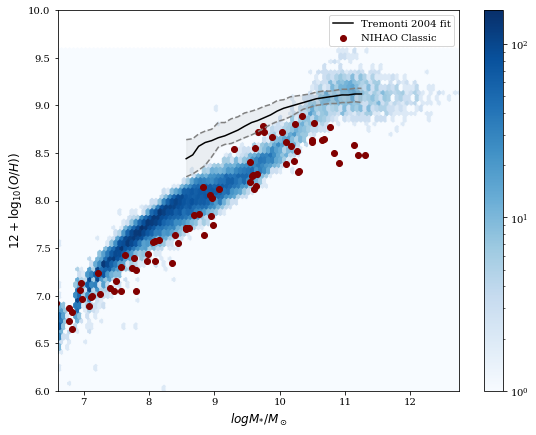

In [28]:
# Oxygen Abundance
def to_log12(z):
    # Assume that oxygen is 35% of the metal mass
    oxy_mass_frac = 0.35*z
    n_oxy_frac = oxy_mass_frac/16.0
    logOH = np.log10(n_oxy_frac)
    return logOH + 12


def plot_oxh(oxh,mstar):
    
    tremonti = np.genfromtxt('/scratch/hc2347/references/obs/Tremonti_2004_mzr.csv',unpack=True,skip_header=2,delimiter=',')
    
    median_tr = tremonti[3]
    sixteen_tr = tremonti[2]
    eightyfour_tr = tremonti[4]
    
    logmstar_tr =tremonti[0]
    
    fig, ax = plt.subplots(figsize = (9,7))
    
    x = np.log10(mstar)
    y = oxh
    
    x,y = do_filter(x,y)
    
    hb = plt.hexbin(x, y, gridsize= 100, bins='log',cmap='Blues')
    plt.colorbar(hb)
    
    ax.plot(logmstar_tr, median_tr, c='black', label = "Tremonti 2004 fit")
    ax.plot(logmstar_tr, sixteen_tr, linestyle='dashed',color='grey')
    ax.plot(logmstar_tr, eightyfour_tr, linestyle='dashed',color='grey')
    ax.fill_between(logmstar_tr, sixteen_tr, y2 = eightyfour_tr, alpha = 0.1, color='grey')
    ax.set_ylabel('$12+\log_{10}(O/H))$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    ax.axis([xmin, xmax, ymin, ymax])
    
    nihao_x = nihao('Mstar',0)
    nihao_y = nihao('oxh',0)
        
    ax.scatter(np.log10(nihao_x), nihao_y, color='maroon', label = "NIHAO Classic")
    
    ax.legend()
    ax.set_ylim(6,10)
    #ax.set_xlim(8.5,12)
    
    plt.savefig("/scratch/hc2347/reports/60/CenterCold_MZR_Oxh.png")

# Load oxygen
oxh = data['oxh']
mstar = data['mstar']
print((oxh[:40]))
print(len(oxh))
oxhnew, mstarnew = do_filter(oxh,mstar)

print((oxh[:40]))

print(len(oxhnew))
print(len(mstarnew))
plot_oxh(oxhnew,mstarnew)

40567
40567
[1.73998967e+06 9.49787888e+08 1.21675802e+06 9.54153250e+07
 5.82806975e+09 6.70345494e+06 1.36801733e+07 2.00599193e+11
 7.50075668e+09 3.64883503e+08]
[0.00021677 0.00110441 0.00018029 0.0006787  0.00909122 0.00029879
 0.00035349 0.03169161 0.01070778 0.00120802]


/home/hc2347/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


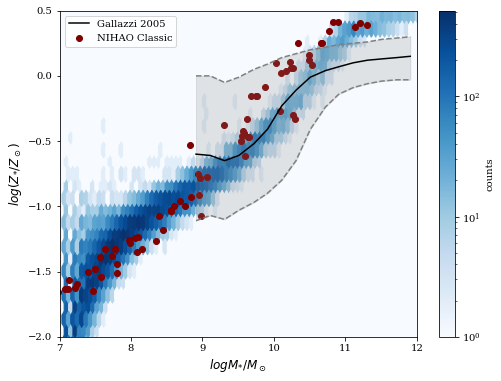

In [30]:
# Stellar Metallicity

def plot_stellar_metallicity(z_star, m_star):

    z_sol = 0.013 # primordial Solar metallicity


    x = np.log10(m_star)
    y = np.log10(z_star/z_sol)
    gallazzi = np.genfromtxt('/scratch/hc2347/references/obs/Gallazzi_2005_zstar.csv',unpack=True,skip_header=2,delimiter=',')
    logmstar_tr = gallazzi[0]

    median_tr = gallazzi[1]
    sixteen_tr = gallazzi[2]
    eightyfour_tr = gallazzi[3]

    fig, ax = plt.subplots(figsize=(8,6))
    
    plt.hexbin(x,y,gridsize=100,bins='log',cmap="Blues")
    cb = plt.colorbar()
    cb.set_label("counts")

    nihao_x = np.array(nihao('Mstar',0))
    nihao_y = np.array([np.sum(z_vals) for z_vals in nihao('z_star',0)])
    print(nihao_x[:10])
    print(nihao_y[:10])
        
    ax.scatter(np.log10(nihao_x), np.log10(nihao_y/z_sol), color='maroon', label = "NIHAO Classic")
    
    
    ax.plot(logmstar_tr, median_tr, c='black',label = "Gallazzi 2005")
    ax.plot(logmstar_tr, sixteen_tr, linestyle='dashed',color='grey')
    ax.plot(logmstar_tr, eightyfour_tr, linestyle='dashed',color='grey')
    
    ax.fill_between(logmstar_tr, sixteen_tr, y2 = eightyfour_tr, alpha = 0.2, color='grey' )
    ax.set_ylabel('$log(Z_{*}/Z_\odot)$',fontsize=12)
    ax.set_xlabel('$ log M_{*}/M_\odot$',fontsize=12)
    ax.legend()

    ax.set_ylim(-2,0.5)
    ax.set_xlim(7,12)
    
    plt.savefig("/scratch/hc2347/reports/60/Center_Gallazzi_SMZR.png")

z_star, m_star = do_filter(data['z_star'],data['mstar'])
print(len(z_star))
print(len(m_star))
plot_stellar_metallicity(z_star, m_star)